In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random 
import numpy as np
from IPython.display import display, clear_output
import time
import math

In [2]:
class driver():
    """Creates a driver capable of picking up riders and taking them to their destination. Drivers may only have 1 rider at a
    time. """
    
    def __init__(self, x_dim, y_dim):
        """Defines a driver whose default location is randomly located within the dimensions of the world and who hasn't been
        hired and doesn't have a rider in their vehicle."""
        self.location = [np.random.randint(0,x_dim), np.random.randint(0,y_dim)]
        self.has_rider = False   # True when rider is in their car
        self.my_rider = "None"   # Corresponds to rider from when the rider selects the driver until they've been dropped off.
        
    def move(self):
        """If the driver has a job, this moves the driver one position closer to their destination or picks up the rider. 
        (If they haven't picked up the rider yet, then their destination is the rider's location. If they 
        have picked up the rider, then their destination is the rider's destination.) The driver first will move right/left, and
        then up/down. (Note: Drivers do not pick up or drop off their passenger and move in the same iteration (i.e. Drivers will
        spend one iteration obtaining their rider.))
        """

        if self.my_rider != "None":       
            if self.has_rider == False:
                if self.location[0] < self.my_rider.location[0]:
                    self.location[0] += 1
                elif self.location[0] > self.my_rider.location[0]:
                    self.location[0] -= 1
                else:
                    if self.location[1] < self.my_rider.location[1]:
                        self.location[1] += 1
                    elif self.location[1] > self.my_rider.location[1]:
                        self.location[1] -= 1
                    else:
                        self.has_rider = True
            elif self.has_rider == True:
                if self.location[0] < self.my_rider.destination[0]:
                    self.location[0] += 1
                    self.my_rider.location[0] += 1
                elif self.location[0] > self.my_rider.destination[0]:
                    self.location[0] -= 1
                    self.my_rider.location[0] -= 1
                else:
                    if self.location[1] < self.my_rider.destination[1]:
                        self.location[1] += 1
                        self.my_rider.location[1] += 1
                    elif self.location[1] > self.my_rider.destination[1]:
                        self.location[1] -= 1
                        self.my_rider.location[1] -= 1                                          
        
    def draw(self):
        """Plots the driver green if they have a rider, red if they don't have a rider."""
        color = 'r'
        if (self.has_rider == True):
            color = 'g'
        plt.scatter(self.location[0], self.location[1], s = 150, color=color);
        

In [3]:
class rider():
    """Creates a driver capable of picking up riders and taking them to their destination. Drivers may only have 1 rider at a
    time. Once assigned to a rider, a driver will their rider directly to their destination immediately."""
    
    def __init__(self, x_dim, y_dim):
        """Defines a rider whose default location is randomly located within the dimensions of the world, who has a
        destination at another location, and who has no driver."""    
        self.location = [np.random.randint(0,x_dim), np.random.randint(0,y_dim)]
        self.destination = [np.random.randint(0,x_dim), np.random.randint(0,y_dim)]
        # Prevents the possibility that the location and destination are the same
        while self.destination == self.location: 
            self.destination = [np.random.randint(0,x_dim), np.random.randint(0,y_dim)]
        self.wait_time = 0    # amount of time rider waits after driver has been selected until they're picked up
        self.ride_time = 0    # amount of interations it takes to be driven to the destination
        
        
    def closest_available_driver(self, available_drivers):
        """ Uses a a list of available drivers to calculate the distance between the rider and all available drivers and assigns
        the closest driver the following rider. Returns the closest driver and their location."""
        
        # Creates a list of driver locations.
        driver_locations = []
        for d in available_drivers:
            driver_locations.append(d.location)
            
        # Determines the nearest driver's location.
        shortest_dist = 99999
        for l in driver_locations:
            dist = math.sqrt( (l[0] - self.location[0])**2 + (l[1] - self.location[1])**2 )
            if dist < shortest_dist:
                shortest_dist = dist
                nearest_driver_location = l
        
        # Determines the nearest driver.
        for d in available_drivers:
            if d.location == nearest_driver_location:
                nearest_driver = d
                
        return nearest_driver, nearest_driver_location
    
    def draw(self):
        """Plots the rider yellow."""
        plt.scatter(self.location[0], self.location[1], s = 150, color='y')
    

In [24]:
def run(num_drivers = 10, rider_spawn_prob = 0.2, x_dim = 70, y_dim = 70, iterations = 100, vis = True):
    """Creates a world of size x_dim by y_dim with the specified number of drivers (red points) and if vis = True runs a 
    simulation in which riders (yellow points) and their destinations (red splotches) spawn according to the given rider spawn
    probability, riders select the closest driver, and said driver picks up the rider and drops them off at their destination.
    Returns a list of wait and ride times for the riders that were transported to their destination and how many riders left
    due to no drivers being available."""
    
    # Initializes an empty array for the world and sets the animation dimensions
    world = np.zeros((x_dim,y_dim))
    if vis == True:
        fig, ax = plt.subplots(figsize=(30,15));
    
    # Creates a list of drivers and available drivers
    drivers = [driver(x_dim,y_dim) for a in range(0,num_drivers)]
    available_drivers = []
    for d in drivers:
        available_drivers.append(d)
    
    # Creates an empty list for riders, rider wait times, and rider ride times
    riders = []
    rider_wait_times = []
    rider_ride_times = []
    dropped_riders = 0
    
    iterations_ran = 0
    
    while iterations_ran < iterations:
        
        if rider_spawn_prob > random.random():
            
            # A new rider & their destination spawn
            new_rider = rider(x_dim,y_dim)   
            riders.append(new_rider)
            world[tuple(new_rider.destination)] = 15
            
            # Assigns the closest available driver to the rider, if there is an available driver.
            if available_drivers != []:
                closest_driver, closest_driver_location = new_rider.closest_available_driver(available_drivers)
                closest_driver.my_rider = new_rider
                available_drivers.remove(closest_driver)
            # Otherwise, the new rider leaves. 
            else:
                world[tuple(new_rider.destination)] -= 15
                riders.remove(new_rider)
                dropped_riders += 1
                
                #print("No available driver. A rider may not have been assigned")
        
        # For each driver, if they have a job they move one step closer towards their destination.
        for d in drivers: 
            d.move()  
            
        # For each rider, adds 1 to their wait time if they're waiting or 1 to their ride time if they're being driven.
        for d in drivers:
            if d.my_rider != "None":
                if d.has_rider == False:
                    d.my_rider.wait_time += 1
                else:
                    d.my_rider.ride_time += 1
        
        # If a driver has the rider and is at their destination, drop the rider off and remove them from the animation.
        for d in drivers:
            if d.my_rider != "None":
                if d.my_rider.destination == d.location:
                    # Record wait and ride times to lists
                    rider_wait_times.append(d.my_rider.wait_time)
                    rider_ride_times.append(d.my_rider.ride_time)
                    # Driver drops rider off and remove them from the animation
                    riders.remove(d.my_rider)
                    world[tuple(d.my_rider.destination)] = 0
                    d.has_rider = False
                    d.my_rider = "None"
                    available_drivers.append(d)
                    
        iterations_ran += 1
        
        if vis == True:
            # Plots the world
            plt.imshow(world.T, origin='lower', aspect='equal');
            plt.text(x_dim - 8, y_dim - 2,'Dropped Riders: %s' %dropped_riders, color='w', size = 15, horizontalalignment='center', verticalalignment='center')
            for r in range(0,len(riders)):
                riders[r].draw()
            for d in range(0,num_drivers):
                drivers[d].draw()

            # Allows animation
            clear_output(wait=True) # Clear output for dynamic display
            display(fig)            # Reset display
            fig.clear()             # Prevent overlapping and layered plots
            time.sleep(0.0001)      # Sleep for a fraction of a second to allow animation to catch up
            
    return rider_wait_times, rider_ride_times, dropped_riders
    

Red Points: Drivers without passenger  
Green Points: Drivers with passenger  
Yellow Points: Passenger waiting to be picked up  
Red Splotches: Passenger destination

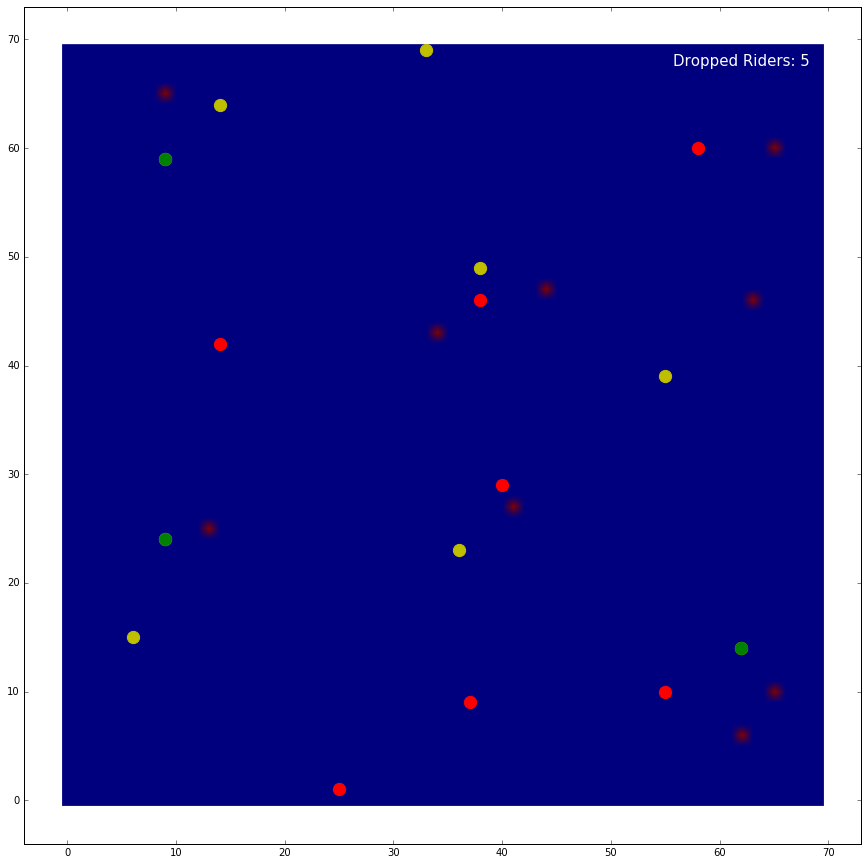

In [25]:
wait_times, ride_times, dropped_riders = run(num_drivers = 10)

In [6]:
print(wait_times)
print(ride_times)
print("The number of riders that left:", dropped_riders)

[14, 6, 12, 24]
[14, 54, 27, 20]
The number of riders that left: 6


***Extra Ideas***

-Would it be nice to compare the costs of having drivers being able to change the rider that they're moving towards for a more efficient system?    
    
-Try using nearest neighbor algorithm to speed up driver selection of rider

-It may make sense to create an additional list of only the visible riders (i.e. those that aren't being driven). Currently drivers are just drawn over their riders.